In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder
import pickle


from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
path = 'C:/Users/caiqu/OneDrive/Competitions/sony/input/'

In [4]:
# Reading Data
df_train = pd.read_csv(path+'df_train_under.csv')
df_test = pd.read_csv(path+'df_test.csv')
df_valid = pd.read_csv(path+'df_validation_under.csv')

In [5]:
#selecting text columns
text_columns = ['PLOT_SUMMARY', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'SRC_TITLE_NM']

### Text Pre-process

In [6]:
# Pré-processamento dos textos e tokenização
def preprocess_text(text):
    return simple_preprocess(text)

# Função para calcular a média dos vetores de palavras em um texto
def text_to_vector(text, model):
    vectors = [model.wv[word] for word in text if word in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
    
# Dicionário para armazenar os modelos Word2Vec
word2vec_models = {}

# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_train[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_train[f'{column}_VECTOR'] = df_train[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    
    
    # Dicionário para armazenar os modelos Word2Vec
word2vec_models = {}

# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_test[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_test[f'{column}_VECTOR'] = df_test[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Extrair os textos da coluna
    texts = df_valid[column].astype(str).tolist()
    
    # Tokenizar os textos
    tokens = [preprocess_text(text) for text in texts]
    
    # Treinar o modelo Word2Vec
    word2vec_model = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4)
    
    # Armazenar o modelo no dicionário
    word2vec_models[column] = word2vec_model

    # Aplicar a função para converter textos em vetores e criar uma nova coluna no DataFrame
    df_valid[f'{column}_VECTOR'] = df_valid[column].astype(str).apply(lambda text: text_to_vector(preprocess_text(text), word2vec_model))
    

In [7]:
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_train = pd.concat([df_train.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_train[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_test = pd.concat([df_test.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_test[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)
    
# Loop sobre as colunas textuais
for column in text_columns:
    # Expandir a coluna de vetores em colunas separadas
    df_valid = pd.concat([df_valid.drop(columns=[f'{column}_VECTOR']), 
                          pd.DataFrame(df_valid[f'{column}_VECTOR'].tolist(), 
                                       columns=[f'{column}_VECTOR_{i}' for i in range(100)])], axis=1)

### PCA Extraction from Text Vectors

In [8]:
def apply_pca(df):
    # Selecionar colunas que contêm '_VECTOR'
    vector_columns = [col for col in df.columns if '_VECTOR' in col]

    # Criar matriz com os vetores das colunas selecionadas
    vectors_matrix = df[vector_columns].values

    # Aplicar PCA
    pca = PCA(n_components=15)  # Manter 95% da variância explicada
    pca_result = pca.fit_transform(vectors_matrix)

    # Adicionar colunas de PCA ao DataFrame
    for i in range(pca_result.shape[1]):
        df[f'PCA_{i+1}'] = pca_result[:, i]

    # Remover colunas com sufixo '_VECTOR'
    df = df.drop(columns=[col for col in df.columns if '_VECTOR' in col])

    return df

In [9]:
# Exemplo de uso
df_train = apply_pca(df_train)
df_valid = apply_pca(df_valid)
df_test = apply_pca(df_test)

In [10]:
df_train['SRC_GENRE_ENCODED'].value_counts()

6.0    2954
5.0    2700
3.0    2164
1.0    1068
7.0     670
4.0     417
2.0     266
Name: SRC_GENRE_ENCODED, dtype: int64

In [11]:
# df_train.head()

### Selecting and filtring Features for the Model

In [12]:
#Select Features
columns_to_drop = ['PLOT_OUTLINE_SENTIMENT', 'PLOT_MEDIUM_SENTIMENT', 'PLOT_SUMMARY_SENTIMENT', 'SRC_TITLE_NM_SENTIMENT',
'SRC_TITLE_ID', 'SRC_TITLE_NM', 'TITLE_TYPE', 'RELEASE_DT', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'PLOT_SUMMARY', 'SRC_GENRE']

# Remover as colunas dos conjuntos de treinamento e teste
df_train.drop(columns=columns_to_drop, inplace=True)
df_valid.drop(columns=columns_to_drop, inplace=True)

In [13]:
columns_to_drop = ['PLOT_OUTLINE_SENTIMENT', 'PLOT_MEDIUM_SENTIMENT', 'PLOT_SUMMARY_SENTIMENT', 'SRC_TITLE_NM_SENTIMENT',
'SRC_TITLE_ID', 'SRC_TITLE_NM', 'TITLE_TYPE', 'RELEASE_DT', 'PLOT_OUTLINE', 'PLOT_MEDIUM', 'PLOT_SUMMARY']

df_test.drop(columns=columns_to_drop, inplace=True)

In [14]:
df_train.head()

,ID,TITLE_YR,RUN_TIME,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,RELEASE_DAY,RELEASE_MONTH,PLOT_SUMMARY_SENTIMENT_ENCODED,SRC_TITLE_NM_SENTIMENT_ENCODED,PLOT_OUTLINE_SENTIMENT_ENCODED,PLOT_MEDIUM_SENTIMENT_ENCODED,PLOT_SUMMARY_DOMINANT_TOPIC,PLOT_OUTLINE_DOMINANT_TOPIC,PLOT_MEDIUM_DOMINANT_TOPIC,SRC_TITLE_NM_DOMINANT_TOPIC,SRC_GENRE_ENCODED,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
0,11005,2022,98.0,0.52,157,300000.0,18.0,9.0,3.0,2.0,3.0,3.0,6,8,9,6,6.0,0.161787,-2.617937,0.610108,1.275975,-0.464055,-0.455664,0.496602,0.366878,-0.132868,-0.878692,0.250092,0.128888,-0.144012,0.220708,0.129473
1,10717,2013,85.0,0.64,623,300000.0,19.0,7.0,1.0,2.0,2.0,1.0,7,0,7,0,3.0,-3.381257,1.048318,-0.092387,-0.214607,0.456714,-0.043482,-0.034275,-0.165391,0.263415,0.011100,0.018847,0.136200,0.198359,0.073471,-0.105477
2,7218,2023,92.0,0.88,70,2500000.0,1.0,6.0,3.0,2.0,3.0,2.0,7,7,0,1,3.0,2.660629,1.273911,0.700445,0.171789,0.052913,0.287787,-0.183049,-0.044125,0.108890,0.086110,0.106912,-0.107923,0.028763,-0.014426,0.028490
3,3368,2008,108.0,0.67,41,300000.0,15.0,2.0,1.0,2.0,1.0,2.0,2,2,0,0,1.0,3.247098,0.921012,-0.193955,-0.022421,-0.093454,-0.109226,0.393537,-0.009871,0.012203,0.136711,-0.187505,0.109374,0.051359,-0.058480,-0.049079
4,8558,2014,101.0,0.52,907,300000.0,12.0,5.0,1.0,2.0,1.0,3.0,2,2,9,0,6.0,1.195116,-2.008280,0.268810,-0.249234,0.335716,0.730126,0.354914,-0.156376,-0.232997,-0.235156,-0.072017,-0.009799,0.344234,-0.102233,-0.231358


### LGBM Modelling

In [15]:
# Separar features e target
X = df_train.drop(columns=['SRC_GENRE_ENCODED'])
y = df_train['SRC_GENRE_ENCODED']

In [16]:
# Dividir os dados em treino e validação
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [17]:
df_train.head()

,ID,TITLE_YR,RUN_TIME,RATING_AVG,NO_OF_VOTES,BUDGET_AMT,RELEASE_DAY,RELEASE_MONTH,PLOT_SUMMARY_SENTIMENT_ENCODED,SRC_TITLE_NM_SENTIMENT_ENCODED,PLOT_OUTLINE_SENTIMENT_ENCODED,PLOT_MEDIUM_SENTIMENT_ENCODED,PLOT_SUMMARY_DOMINANT_TOPIC,PLOT_OUTLINE_DOMINANT_TOPIC,PLOT_MEDIUM_DOMINANT_TOPIC,SRC_TITLE_NM_DOMINANT_TOPIC,SRC_GENRE_ENCODED,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,PCA_12,PCA_13,PCA_14,PCA_15
0,11005,2022,98.0,0.52,157,300000.0,18.0,9.0,3.0,2.0,3.0,3.0,6,8,9,6,6.0,0.161787,-2.617937,0.610108,1.275975,-0.464055,-0.455664,0.496602,0.366878,-0.132868,-0.878692,0.250092,0.128888,-0.144012,0.220708,0.129473
1,10717,2013,85.0,0.64,623,300000.0,19.0,7.0,1.0,2.0,2.0,1.0,7,0,7,0,3.0,-3.381257,1.048318,-0.092387,-0.214607,0.456714,-0.043482,-0.034275,-0.165391,0.263415,0.011100,0.018847,0.136200,0.198359,0.073471,-0.105477
2,7218,2023,92.0,0.88,70,2500000.0,1.0,6.0,3.0,2.0,3.0,2.0,7,7,0,1,3.0,2.660629,1.273911,0.700445,0.171789,0.052913,0.287787,-0.183049,-0.044125,0.108890,0.086110,0.106912,-0.107923,0.028763,-0.014426,0.028490
3,3368,2008,108.0,0.67,41,300000.0,15.0,2.0,1.0,2.0,1.0,2.0,2,2,0,0,1.0,3.247098,0.921012,-0.193955,-0.022421,-0.093454,-0.109226,0.393537,-0.009871,0.012203,0.136711,-0.187505,0.109374,0.051359,-0.058480,-0.049079
4,8558,2014,101.0,0.52,907,300000.0,12.0,5.0,1.0,2.0,1.0,3.0,2,2,9,0,6.0,1.195116,-2.008280,0.268810,-0.249234,0.335716,0.730126,0.354914,-0.156376,-0.232997,-0.235156,-0.072017,-0.009799,0.344234,-0.102233,-0.231358


Once parameters tunning was not the focus, the only change at the default parameters was the learning_rate.

In [18]:
# Definir os parâmetros do modelo LGBM
params = {
    'objective': 'multiclass',
    'num_class': len(y.unique())+1,
    'metric': 'multi_logloss',
    'learning_rate': 0.001,
#     'num_leaves': 31,
#     'max_depth': -1,
#     'subsample': 0.8,
#     'colsample_bytree': 0.8,
    'verbosity': -1,
    'seed': 42
}


# Criar conjunto de dados para treino e validação
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)



# Callbacks
callbacks = [
    lgb.log_evaluation(period = 500), lgb.early_stopping(stopping_rounds=150, first_metric_only=False, verbose=True)
]

# Treinar o modelo LGBM
model = lgb.train(params, train_data, num_boost_round=10000, valid_sets=[train_data, valid_data], callbacks=callbacks)


Training until validation scores don't improve for 150 rounds
[500]	training's multi_logloss: 1.32616	valid_1's multi_logloss: 1.44274
[1000]	training's multi_logloss: 1.14759	valid_1's multi_logloss: 1.3542
[1500]	training's multi_logloss: 1.02538	valid_1's multi_logloss: 1.31086
[2000]	training's multi_logloss: 0.931687	valid_1's multi_logloss: 1.28635
[2500]	training's multi_logloss: 0.85532	valid_1's multi_logloss: 1.27235
[3000]	training's multi_logloss: 0.791294	valid_1's multi_logloss: 1.26631
[3500]	training's multi_logloss: 0.736793	valid_1's multi_logloss: 1.26306
[4000]	training's multi_logloss: 0.688013	valid_1's multi_logloss: 1.26164
Early stopping, best iteration is:
[4243]	training's multi_logloss: 0.66633	valid_1's multi_logloss: 1.26147


### Exploring Training/Validating Phase

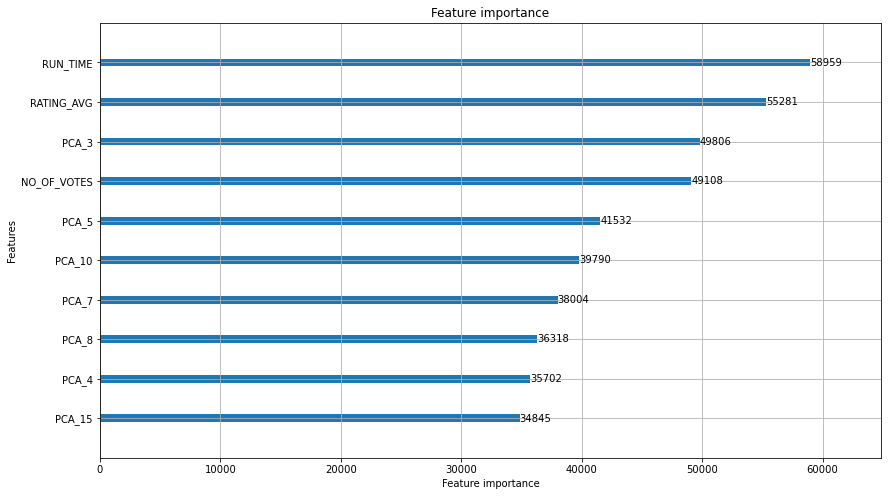

In [19]:
# Plotar a importância das features
lgb.plot_importance(model, figsize=(14, 8), max_num_features=10)
plt.show()

### Outsample Validation

In [20]:
# Fazer previsões para o conjunto de validação
predictions = model.predict(df_valid.drop(columns=['SRC_GENRE_ENCODED']), num_iteration=model.best_iteration)
df_valid['predictions'] = np.argmax(predictions, axis=1)  # Assumindo que você deseja adicionar a classe prevista com a maior probabilidade

In [21]:
# Calcular a acurácia geral
overall_accuracy = accuracy_score(df_valid['SRC_GENRE_ENCODED'], df_valid['predictions'])
print("Overall Accuracy:", overall_accuracy)

# Calcular a matriz de confusão
cm = confusion_matrix(df_valid['SRC_GENRE_ENCODED'], df_valid['predictions'])

# Obter os gêneros únicos
unique_genres = df_valid['SRC_GENRE_ENCODED'].unique()

# Calcular a acurácia por gênero
genre_accuracies = {}
for genre in unique_genres:
    mask = df_valid['SRC_GENRE_ENCODED'] == genre
    genre_accuracy = accuracy_score(df_valid['SRC_GENRE_ENCODED'][mask], df_valid['predictions'][mask])
    genre_accuracies[genre] = genre_accuracy

# Imprimir acurácia por gênero
for genre, accuracy in genre_accuracies.items():
    print(f"Accuracy for Genre {genre}: {accuracy}")

Overall Accuracy: 0.516728624535316
Accuracy for Genre 6.0: 0.5423728813559322
Accuracy for Genre 4.0: 0.043478260869565216
Accuracy for Genre 1.0: 0.40384615384615385
Accuracy for Genre 3.0: 0.40707964601769914
Accuracy for Genre 5.0: 0.8217054263565892
Accuracy for Genre 2.0: 0.0
Accuracy for Genre 7.0: 0.3076923076923077


### Predctions for Test_set

In [22]:
predictions = model.predict(df_test, num_iteration=model.best_iteration)

In [23]:
df_test['predictions'] = np.argmax(predictions, axis=1) 

In [24]:
def decode_predictions(df, column_name, encoder):
    # Crie uma cópia do DataFrame para evitar alterações indesejadas
    df_decoded = df.copy()
    
    # Use o encoder fornecido para decodificar os valores
    df_decoded[f"{column_name}_DECODED"] = encoder.inverse_transform(df[[column_name]]-1)
    
    return df_decoded

In [25]:
df_train = pd.read_csv(path+'df_train_under.csv')
encoder = OrdinalEncoder()
encoder.fit(df_train[['SRC_GENRE']])

OrdinalEncoder()

In [26]:
df_test = decode_predictions(df_test, 'predictions', encoder)

In [27]:
df_test[[ 'ID','predictions_DECODED']].to_csv('output/LGBM_US_test_set_predctions.csv', index=False)